In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
%cd /content/drive/MyDrive/Colab Notebooks/Semantic/Onion

In [ ]:
!nvidia-smi

In [ ]:
!pip install contractions

In [1]:
# magic for autoreloading of modules
%reload_ext autoreload
%autoreload 2

import contractions
import pandas as pd
import torch
import torch.nn.functional as F

from torch.utils.data import DataLoader
from torch.optim import AdamW
from transformers import DistilBertTokenizer, AutoModelForSequenceClassification, AutoTokenizer, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split

from utils import set_seed, plot_confusion_matrix, plot_training_history
from dataloader import OnionDataset
from trainer import train_model, evaluate_model, freeze_transformer_layers, inference

In [2]:
# Set seed for reproducibility
seed = 123
set_seed(seed)

In [3]:
df = pd.read_csv("data/OnionOrNot.csv")
print(f"{df.shape=}")
print()
df.head()

df.shape=(24000, 2)



,text,label
0,Entire Facebook Staff Laughs As Man Tightens P...,1
1,Muslim Woman Denied Soda Can for Fear She Coul...,0
2,Bold Move: Hulu Has Announced That They’re Gon...,1
3,Despondent Jeff Bezos Realizes He’ll Have To W...,1
4,"For men looking for great single women, online...",1


In [4]:
df.describe(include='all')

,text,label
count,24000,24000.000000
unique,23998,NaN
top,Area Satirical Publication The Onion Sold To U...,NaN
freq,2,NaN
mean,NaN,0.375000
std,NaN,0.484133
min,NaN,0.000000
25%,NaN,0.000000
50%,NaN,0.000000
75%,NaN,1.000000


Check for null values in the dataset

In [5]:
(df["text"].isnull() | (df["text"].str.strip() == "")).sum()

0

Data cleaning
- Convert to lowercase
- Trim whitespace
- Normalize spacing
- Remove URLs
- Expand contractions: Converts contracted words (e.g., "can't") into their expanded forms (e.g., "cannot").

In [6]:
df["text"] = df["text"].str.lower()
df["text"] = df["text"].str.strip()
df["text"] = df["text"].str.replace(r'\s+', ' ', regex=True)
df["text"] = df["text"].str.replace(r"http\S+|www\S+|https\S+", "", regex=True)
df["text"] = df["text"].apply(lambda x: contractions.fix(x))


In [7]:
df.sample(10)

,text,label
3262,heartbreaking: dad is excited out of his fucki...,1
7089,teen wastes prime childbearing years going to ...,1
8472,pornhub unveils its ‘bonerless bathing suit’ t...,0
4761,obama accepts transparency award... behind clo...,0
14539,tearful gun manufacturers thankful they all ma...,1
11483,only one person in the whole you.k. showed up ...,0
21694,man at gym apparently comfortable standing nak...,1
4996,plane makes emergency landing after passenger ...,0
16397,new documentary reveals seaworld forced orca w...,1
9043,"police, firefighters called in after flat eart...",0


New columns: word count and character count

In [8]:
df['WordCount'] = df['text'].apply(lambda x: len(str(x).split(" ")))
df['CharCount'] = df['text'].str.len()
df.head()

,text,label,WordCount,CharCount
0,entire facebook staff laughs as man tightens p...,1,9,61
1,muslim woman denied soda can for fear she coul...,0,14,66
2,bold move: hulu has announced that they are go...,1,26,139
3,despondent jeff bezos realizes he will have to...,1,20,103
4,"for men looking for great single women, online...",1,23,147


<Axes: title={'center': 'Distribution of Labels'}, xlabel='label'>

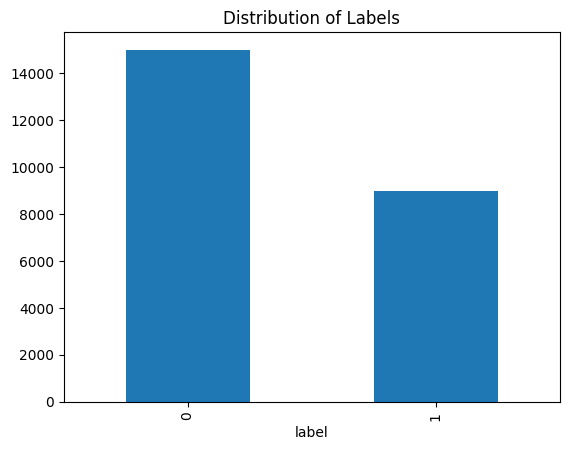

In [9]:
# Count the labels
label_counts = df['label'].value_counts()

# Plot the distribution
label_counts.plot(kind='bar', title='Distribution of Labels')

array([<Axes: title={'center': 'WordCount'}, xlabel='label'>,
       <Axes: title={'center': 'CharCount'}, xlabel='label'>],
      dtype=object)

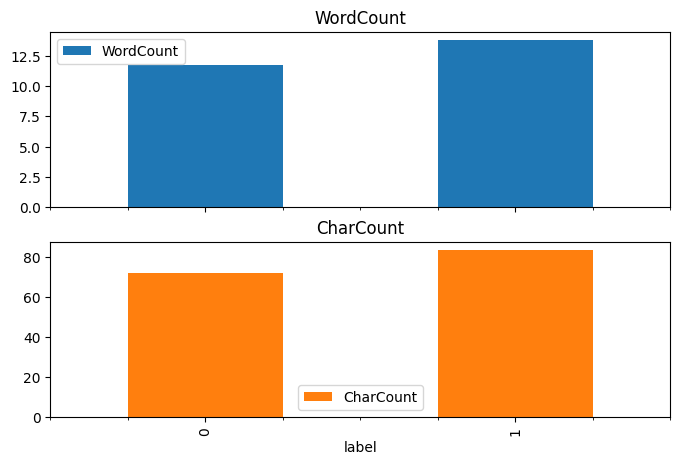

In [10]:
df_numeric = df.select_dtypes(include=['number']) 
df_numeric.groupby('label').mean().plot.bar(subplots=True, figsize=(8,5), grid=False)


Stratified train-test split

In [11]:
# Split the data
train_df, val_df = train_test_split(df, test_size=0.2, random_state=seed, stratify=df['label'])

Loading DeBerta model from huggingface

In [ ]:
# Model configuration
model_name = "microsoft/deberta-base"

# Initialize tokenizer and model using Auto classes
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=2,
    output_attentions=False,
    output_hidden_states=False
)

Some weights of DebertaForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Random token dropout in train dataset to avoid overfitting

In [14]:
# Create datasets
train_dataset = OnionDataset(
    train_df['text'].values,
    train_df['label'].values,
    tokenizer,
    max_length=128,
    token_dropout_prob=0.1
)

val_dataset = OnionDataset(
    val_df['text'].values,
    val_df['label'].values,
    tokenizer,
    max_length=128,
    token_dropout_prob=0.0
)

In [16]:
# Create data loaders
kwargs = {'num_workers': 8, 'pin_memory': True} if torch.cuda.is_available() else \
        {'num_workers': 0} if torch.backends.mps.is_available() else \
        {}
batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, **kwargs)

In [17]:
# Initialize model
device = torch.device("cuda" if torch.cuda.is_available()
                    else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

model = model.to(device)

Using device: cuda


In [18]:
learning_rate = 2e-5
epochs = 5

# Only optimize classifier parameters
optimizer = AdamW(
    [p for p in model.parameters() if p.requires_grad],
    lr=learning_rate
)

In [19]:
total_steps = len(train_loader) * epochs
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=int(0.1 * total_steps),
    num_training_steps=total_steps
)

In [20]:
print("Starting training...")

train_losses, train_accuracies, val_losses, val_accuracies = \
        train_model(model, tokenizer, train_loader, val_loader, optimizer, scheduler, num_epochs=epochs, device=device)

print("Training completed!")

print(f"Best validation accuracy: {max(val_accuracies):.4f}")


Starting training...
Epoch 1/5


  0%|          | 0/300 [00:00<?, ?batch/s]

Train Loss: 0.4179, Train Accuracy: 78.64
Test Loss: 0.2290, Test Accuracy: 91.08
New best model saved! Validation Accuracy: 91.08%
------------------------------------------------------------
Epoch 2/5


  0%|          | 0/300 [00:00<?, ?batch/s]

Train Loss: 0.2394, Train Accuracy: 90.30
Test Loss: 0.1987, Test Accuracy: 92.15
New best model saved! Validation Accuracy: 92.15%
------------------------------------------------------------
Epoch 3/5


  0%|          | 0/300 [00:00<?, ?batch/s]

Train Loss: 0.1749, Train Accuracy: 93.36
Test Loss: 0.1907, Test Accuracy: 92.73
New best model saved! Validation Accuracy: 92.73%
------------------------------------------------------------
Epoch 4/5


  0%|          | 0/300 [00:00<?, ?batch/s]

Train Loss: 0.1304, Train Accuracy: 95.09
Test Loss: 0.2221, Test Accuracy: 93.10
New best model saved! Validation Accuracy: 93.10%
------------------------------------------------------------
Epoch 5/5


  0%|          | 0/300 [00:00<?, ?batch/s]

Train Loss: 0.1073, Train Accuracy: 95.92
Test Loss: 0.2186, Test Accuracy: 93.31
New best model saved! Validation Accuracy: 93.31%
Final model saved! Validation Accuracy: 93.31%
------------------------------------------------------------
Training completed!
Best validation accuracy: 93.3125


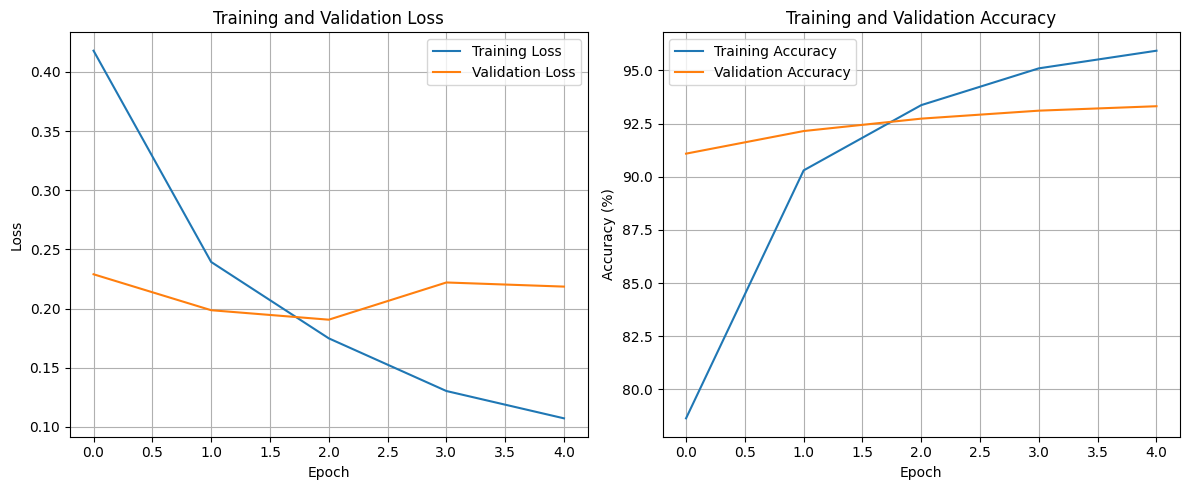

In [21]:
plot_training_history(train_losses, val_losses, train_accuracies, val_accuracies)

In [22]:
print("Loading best model for inference...")

loaded_model = AutoModelForSequenceClassification.from_pretrained("model/best")
loaded_tokenizer = AutoTokenizer.from_pretrained("model/best")

print("Model loaded successfully!")

Loading best model for inference...
Model loaded successfully!


In [23]:
# Final evaluation
print("Running final evaluation...")

test_results = evaluate_model(model, val_loader, device, return_reports=True, return_misclassified=True)

Running final evaluation...


In [24]:
print(f"Final Validation Accuracy: {test_results['accuracy']:.2f}%")

print()
print("Final Classification Report:")
print(test_results['classification_report'])


Final Validation Accuracy: 93.31%

Final Classification Report:
              precision    recall  f1-score   support

    NotOnion       0.94      0.96      0.95      3000
       Onion       0.93      0.89      0.91      1800

    accuracy                           0.93      4800
   macro avg       0.93      0.92      0.93      4800
weighted avg       0.93      0.93      0.93      4800



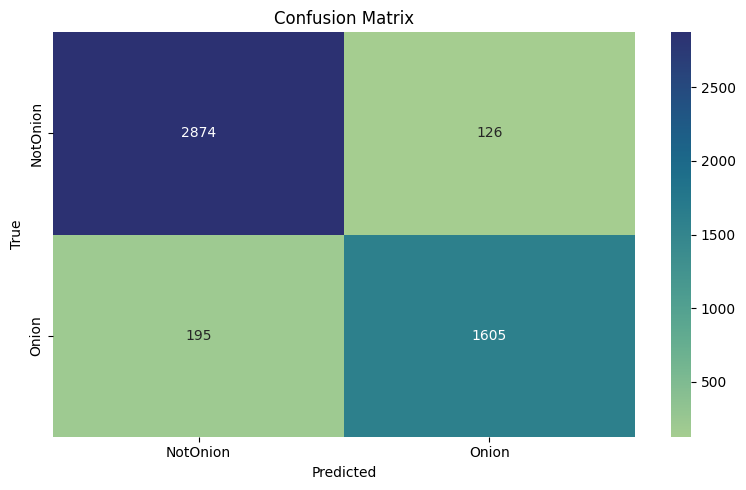

In [25]:
# Plot final confusion matrix
label = ["NotOnion", "Onion"]
plot_confusion_matrix(test_results['confusion_matrix'], labels=label, figsize=(8, 5))


In [26]:
print("Misclassified Examples:")

for example in test_results['misclassified_examples']:
    print()
    print(f"Text: {example['text']}")
    print(f"True Label: {example['true_label']}")
    print(f"Predicted Label: {example['predicted_label']}")
    print(f"Prediction Probabilities: {example['probabilities']}")
    print("========================================================================")

Misclassified Examples:

Text: man crushed to death by giant john paul ii crucifix
True Label: NotOnion
Predicted Label: Onion
Prediction Probabilities: [0.26409304 0.73590696]

Text: authorities praise twitter users' rapid response to virginia shooting
True Label: Onion
Predicted Label: NotOnion
Prediction Probabilities: [0.7654832  0.23451683]

Text: 'the internship' poised to be biggest comedy of 2005
True Label: Onion
Predicted Label: NotOnion
Prediction Probabilities: [0.91964066 0.08035931]

Text: hillary clinton goes unnoticed in ohio chipotle
True Label: NotOnion
Predicted Label: Onion
Prediction Probabilities: [0.02688992 0.9731101 ]

Text: islam is incompatible with country-western culture (by a cowboy)
True Label: Onion
Predicted Label: NotOnion
Prediction Probabilities: [0.98610955 0.01389047]

Text: republicans start donating to marianne williamson to keep her in future democratic debates
True Label: NotOnion
Predicted Label: Onion
Prediction Probabilities: [0.00506689 0.9

In [27]:
print("Running example inference...")
example_text = "Man With Fogged-Up Glasses Forced To Finish Soup Using Other Senses"

result = inference(model, tokenizer, example_text, device)

print(f"Text: {result['text']}")
print(f"Prediction: {result['prediction']}")
print(f"Confidence: {result['confidence']:.2%}")
print("\nProbabilities:")
for label, prob in result['probabilities'].items():
    print(f"{label}: {prob:.2%}")

Running example inference...
Text: Man With Fogged-Up Glasses Forced To Finish Soup Using Other Senses
Prediction: Onion
Confidence: 87.76%

Probabilities:
NotOnion: 12.24%
Onion: 87.76%
